In [42]:
import torch
import numpy as np
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import CNNEmbedding, FCEmbedding
from sbi.inference import NPE, simulate_for_sbi
from sbi.utils import BoxUniform
from sbi import analysis

import pickle
import torch.nn as nn

from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq
from scipy.stats import skew, kurtosis

from scipy.fft import rfft, rfftfreq
from scipy.stats import entropy

from scipy.signal import savgol_filter

from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

import matplotlib.pyplot as plt

In [43]:
# Generate random input signal
num_simulations = 100000
num_samples = 100
t_max = 10
num_timesteps = 64
noise_std = 0.0025

# np.random.seed(4) # unsure if still need this here
seed = 42

# Generate random input signal
x_data = np.abs(np.cumsum(np.random.rand(num_samples, num_timesteps, 1) - 0.5, axis=1))
t_data = np.linspace(0, t_max, num_timesteps)

# Interpolate input signal to match time resolution
t = np.linspace(0, t_max, 500)
input_signal = np.interp(t, t_data, x_data[0, :, 0])

In [44]:
ts, dt = 30.0, 0.1
steps = int(ts / dt)

def amv(theta, tau_sequence=None, noise_std=0.0, seed=None):
    
    if seed is not None:
        np.random.seed(seed)

    Xu, Xuu, Yv, Yvv, Yr, Nv, Nr, Nrr = theta

    m   = 23.8
    Iz   = 1.76
    xg   = 0.046

    Xud  = -2
    Yvd  = -10
    Yrd  = 0
    Nvd  = 0
    Nrd  = -1

    m11 = m - Xud
    m22 = m - Yvd
    m23 = m * xg - Yrd
    m32 = m * xg - Nvd
    m33 = Iz - Nrd
    mt = m22 * m33 - m23 * m32

    a1 = dt * (m - Yvd) / (m - Xud)
    a2 = dt * (m * xg - Yrd) / (m - Xud)
    a3 = (-dt * (Iz - Nrd) * (m - Xud) / mt) + (dt * (m * xg - Yrd) * (m * xg - Yrd) / mt)
    a4 = dt * (m * xg - Yrd) * (Xud - Yvd) / mt
    a5 = (dt * (m * xg - Nvd) * (m - Xud) / mt) - (dt * (m - Yvd) * (m * xg - Yrd) / mt)
    a6 = -dt * (m - Yvd) * (Xud - Yvd) / mt

    b1  = dt * Xu / (m - Xud)
    b2  = dt * Xuu / (m - Xud)
    b3  = (dt * (Iz - Nrd) * Yv / mt) - (dt * (m * xg - Yrd) * Nv / mt)
    b4  = (dt * (Iz - Nrd) * Yr / mt) - (dt * (m * xg - Yrd) * Nr / mt)
    b5  = dt * (Iz - Nrd) * Yvv / mt
    b6  = -dt * (m * xg - Yrd) * Nrr / mt
    b7  = (dt * (m - Yvd) * Nv / mt) - (dt * (m * xg - Nvd) * Yv / mt)
    b8  = (dt * (m - Yvd) * Nr / mt) - (dt * (m * xg - Nvd) * Yr / mt)
    b9  = -dt * (m * xg - Nvd) * Yvv / mt
    b10 = dt * (m - Yvd) * Nrr / mt

    M = np.array([[m11, 0, 0], [0, m22, m23], [0, m32, m33]])
    B = dt * np.linalg.inv(M)
    
    zeta = np.array([
        a1, a2, b1, b2, a3, a4, b3, b4, b5, b6, a5, a6, b7, b8, b9, b10
    ])

    # Control input (default = fixed)
    if tau_sequence is None:
        tau_sequence = np.tile(np.array([[5, 10, 0]]), (steps, 1))

    # Initial state
    u, v, r = 0.0, 0.0, 0.0
    trajectory = []

    for i in range(steps):
        # Compute nonlinear basis vector f(ν_k)

        u_clamp = np.clip(u, -50, 50)
        v_clamp = np.clip(v, -50, 50)
        r_clamp = np.clip(r, -10, 10)

        f = np.array([
            [v_clamp * r_clamp, r_clamp**2, u_clamp, abs(u_clamp) * u_clamp, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, u_clamp * r_clamp, u_clamp * v_clamp, v_clamp, r_clamp, abs(v_clamp) * v_clamp, abs(r_clamp) * r_clamp, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, u_clamp * r_clamp, u_clamp * v_clamp, v_clamp, r_clamp, abs(v_clamp) * v_clamp, abs(r_clamp) * r_clamp]
        ])

        # Compute state update
        dnu = f @ zeta + (B @ tau_sequence[i].reshape(3, 1)).flatten()

        # Add noise if requested
        if noise_std > 0:
            dnu += np.random.normal(scale=noise_std, size=3)

        # Update state
        u, v, r = u + dnu[0], v + dnu[1], r + dnu[2]

        # Save state
        trajectory.append([u, v, r])

    return torch.tensor(trajectory, dtype=torch.float32)

In [45]:
# True parameters
m_true   = 23.8
Iz_true   = 1.76
xg_true   = 0.046

Xud_true  = -2
Yvd_true  = -10
Yrd_true  = 0
Nvd_true  = 0
Nrd_true  = -1

Xu_true   = -0.7225
Xuu_true  = -1.3274
Yv_true   = -0.8612
Yvv_true  = -36.2823
Yr_true   = 0.1079
Nv_true   = 0.1052
Nr_true  = -0.5
Nrr_true = -1

true_params = torch.tensor([Xu_true, Xuu_true, Yv_true, Yvv_true, Yr_true, Nv_true, Nr_true, Nrr_true])

In [51]:
low = np.array([-2.0, -2.0, -2.0, -50.0, -1.0, -1.0, -1.5, -2.0])
high = np.array([0.0, 0.0, 0.0, -20.0, 1.0, 1.0, 0.0, 0.0])
gene_space = [{'low': l, 'high': h} for l, h in zip(low, high)]

In [63]:
import pygad

theta_true = [Xu_true, Xuu_true, Yv_true, Yvv_true, Yr_true, Nv_true, Nr_true, Nrr_true]

obs_traj = amv(theta_true, noise_std=0.0, seed=42).numpy()

def fitness_func(ga_instance, solution, solution_idx):
    theta = np.clip(solution, low, high)
    try:
        sim_traj = amv(theta, noise_std=0.0, seed=42).numpy()
        error = np.mean((sim_traj - obs_traj)**2)
        return -error
    except Exception:
        return -1e6

ga_instance = pygad.GA(
    num_generations=1000,
    num_parents_mating=10,
    fitness_func=fitness_func,
    sol_per_pop=100,
    num_genes=8,
    gene_space=gene_space,
    mutation_percent_genes=50,
    mutation_type="random",
    crossover_type="single_point",
    allow_duplicate_genes=False,
    random_mutation_min_val=-0.01,
    random_mutation_max_val=0.01,
    stop_criteria="saturate_20"
)


ga_instance.run()
solution, solution_fitness, _ = ga_instance.best_solution()

In [64]:
print("\nBest parameters found:", solution)
print("True parameters:", true_params.numpy())
print("Parameter error:", solution - true_params.numpy())
print("Fitness (negative MSE):", solution_fitness)


Best parameters found: [-7.27334764e-01 -1.19733115e-01 -5.26723265e-02 -3.88315170e+01
 -4.32158051e-01 -2.94402514e-02 -8.64793587e-01 -6.32072461e-01]
True parameters: [ -0.7225  -1.3274  -0.8612 -36.2823   0.1079   0.1052  -0.5     -1.    ]
Parameter error: [-0.00483474  1.20766685  0.80852765 -2.54921796 -0.54005805 -0.13464025
 -0.36479359  0.36792754]
Fitness (negative MSE): -1.0085617e-05


/home/sam/miniconda3/envs/pandora/lib/python3.11/site-packages/pygad/visualize/plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


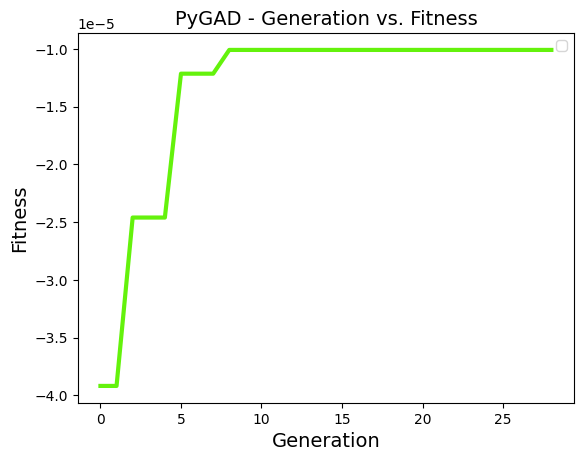

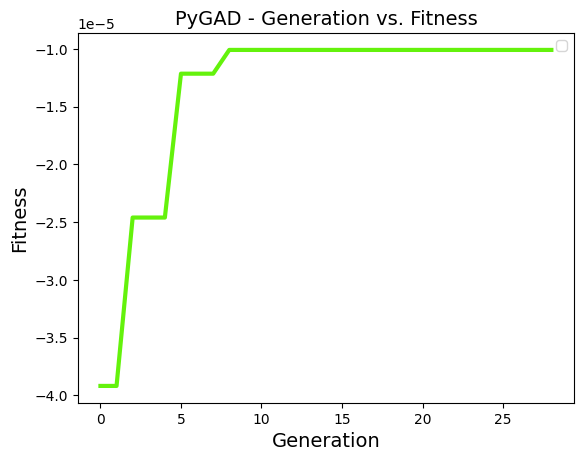

In [65]:
ga_instance.plot_fitness()